## <font color=blue>Diabetes dataset<font>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from tqdm import tqdm
from sklearn.decomposition import PCA



In [2]:
# df = pd.read_csv("diabetic_data.csv", dtype='category').iloc[:500,2:]
df = pd.read_csv("diabetic_data.csv", dtype='category').iloc[:,2:]
df.shape

(101766, 48)

In [3]:
df.corr()

""


In [4]:
df.describe()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,8,26,17,14,18,73,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,1,1,7,3,?,?,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,53990,60234,57494,17756,40256,49949,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


In [5]:
def show_unique(dataF):
    for c in dataF.columns:
        print(c, dataF[c].unique())
        print('*'*50)

show_unique(df)

race [Caucasian, AfricanAmerican, ?, Other, Asian, Hispanic]
Categories (6, object): [Caucasian, AfricanAmerican, ?, Other, Asian, Hispanic]
**************************************************
gender [Female, Male, Unknown/Invalid]
Categories (3, object): [Female, Male, Unknown/Invalid]
**************************************************
age [[0-10), [10-20), [20-30), [30-40), [40-50), [50-60), [60-70), [70-80), [80-90), [90-100)]
Categories (10, object): [[0-10), [10-20), [20-30), [30-40), ..., [60-70), [70-80), [80-90), [90-100)]
**************************************************
weight [?, [75-100), [50-75), [0-25), [100-125), [25-50), [125-150), [175-200), [150-175), >200]
Categories (10, object): [?, [75-100), [50-75), [0-25), ..., [125-150), [175-200), [150-175), >200]
**************************************************
admission_type_id [6, 1, 2, 3, 4, 5, 8, 7]
Categories (8, object): [6, 1, 2, 3, 4, 5, 8, 7]
**************************************************
discharge_disposition_

### <font color =blue>1. remove columns with missing data</font>

In [6]:
#replacing medical speciality with missing
df = df.drop(columns=['weight', 'payer_code'])
df.head(2)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,?,59,0,...,No,Up,No,No,No,No,No,Ch,Yes,>30


### <font color=blue> 2. remove incomplete columns and rows </font>

In [7]:
df = df.drop(columns= df.columns[df.nunique() == 1])

In [8]:
#show_unique(df)
df.shape

(101766, 44)

### <font color = blue>3. categorical variables</font>

In [9]:
to_num = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
         'num_medications', 'number_outpatient', 'number_emergency',
         'number_inpatient', 'number_diagnoses']

to_cat_codes = list(set(df.columns) - set(to_num))

In [10]:
X_features = list(to_num)
for c in to_cat_codes:
    df[c+'_cat'] = df[c].cat.codes        
    X_features += [c+'_cat']
    
X_features.remove('readmitted_cat')

In [11]:
df['readmitted'].head(11)

0      NO
1     >30
2      NO
3      NO
4      NO
5     >30
6      NO
7     >30
8      NO
9      NO
10    >30
Name: readmitted, dtype: category
Categories (3, object): [<30, >30, NO]

In [12]:
df["readmitted_bin"] = np.where(df.readmitted == '<30', 1, np.where(df.readmitted == '>30',1,0))  
df[["readmitted","readmitted_bin"]].head(10)

,readmitted,readmitted_bin
0,NO,0
1,>30,1
2,NO,0
3,NO,0
4,NO,0
5,>30,1
6,NO,0
7,>30,1
8,NO,0
9,NO,0


In [13]:
df = df.drop(columns = to_cat_codes)

In [14]:
df = df.drop(columns = "readmitted_cat")

In [15]:
df.head(2)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin-rosiglitazone_cat,glyburide_cat,...,chlorpropamide_cat,nateglinide_cat,A1Cresult_cat,insulin_cat,metformin_cat,glimepiride-pioglitazone_cat,admission_source_id_cat,acetohexamide_cat,max_glu_serum_cat,readmitted_bin
0,1,41,0,1,0,0,0,1,0,1,...,1,0,2,1,1,0,0,0,2,0
1,3,59,0,18,0,0,0,9,0,1,...,1,0,2,3,1,0,8,0,2,1


#### <font color=red>Target Mapping: < 30 = 0, >30 = 1, NO = 2, </font>

### <font color=blue>4. split</font>

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'readmitted_bin'], df['readmitted_bin'] , random_state = 0)

In [83]:
print(X_train.shape)
print(y_train.shape)

(76324, 43)
(76324,)


### <font color=blue>5. min max scaling</font>

In [84]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train[to_num]), columns= to_num)
X_test = pd.DataFrame(scaler.transform(X_test[to_num]), columns = to_num)
X_train.shape

(76324, 8)

In [85]:
#Trying to separate cat and Num but not worked out well
#Concatenate Num and cat
# X_train_cat = list(set(X_train.columns) - set(to_num))
# X_test_cat = list(set(X_test.columns) - set(to_num))
# X_train = pd.concat([X_train[X_train_cat],X_train_num], axis = 1)
# X_test = pd.concat([X_test_num,X_test[X_test_cat]], axis = 1)
# print("after",X_train.shape)


#### after scale

## <font color=green> Baseline</font>

In [86]:
%%time
from sklearn.dummy import DummyClassifier

X_train.shape
d_major = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

print('train accuracy: {:.2f}'.format(d_major.score(X_train, y_train)))
print('test accuracy: {:.2f}'.format(d_major.score(X_test, y_test)))

train accuracy: 0.54
test accuracy: 0.54
Wall time: 98.2 ms


Micro-averaged precision = 0.54 (treat instances equally)


C:\Users\DELL\Anaconda3\envs\tfp3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro-averaged precision = 0.27 (treat classes equally)
Micro-averaged f1 = 0.54 (treat instances equally)


C:\Users\DELL\Anaconda3\envs\tfp3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro-averaged f1 = 0.35 (treat classes equally)


C:\Users\DELL\Anaconda3\envs\tfp3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.54      1.00      0.70     13709
          1       0.00      0.00      0.00     11733

avg / total       0.29      0.54      0.38     25442



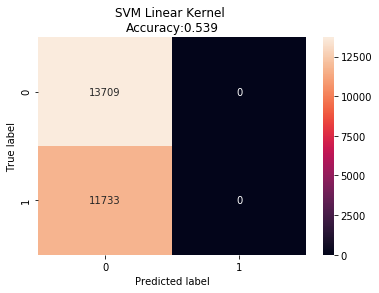

In [87]:
def plot_confusion(clf):
    svm_predicted_mc = clf.predict(X_test)
    confusion_mc = confusion_matrix(y_test, svm_predicted_mc)
    df_cm = pd.DataFrame(confusion_mc, 
                         index = [i for i in range(0,2)], columns = [i for i in range(0,2)])

    plt.figure(figsize=(6,4))
    ax_ticks= ['0','1']
    sns.heatmap(df_cm, annot=True, xticklabels=ax_ticks, yticklabels=ax_ticks, fmt='g')
    plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                           svm_predicted_mc)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(y_test, svm_predicted_mc, average = 'micro')))
    print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(y_test, svm_predicted_mc, average = 'macro')))
    print('Micro-averaged f1 = {:.2f} (treat instances equally)'
          .format(f1_score(y_test, svm_predicted_mc, average = 'micro')))
    print('Macro-averaged f1 = {:.2f} (treat classes equally)'
          .format(f1_score(y_test, svm_predicted_mc, average = 'macro')))
    print(classification_report(y_test, svm_predicted_mc))

plot_confusion(d_major)

[LibLinear]training accuracy: 0.61
test accuracy: 0.62
Micro-averaged precision = 0.62 (treat instances equally)
Macro-averaged precision = 0.62 (treat classes equally)
Micro-averaged f1 = 0.62 (treat instances equally)
Macro-averaged f1 = 0.59 (treat classes equally)
             precision    recall  f1-score   support

          0       0.61      0.82      0.70     13709
          1       0.64      0.38      0.47     11733

avg / total       0.62      0.62      0.59     25442

Wall time: 1.98 s


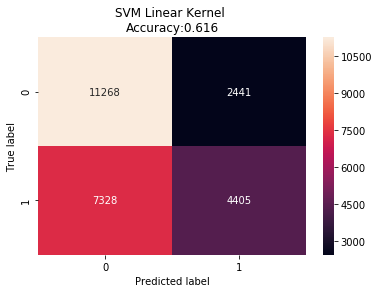

In [88]:
%%time
clf = LinearSVC(verbose=True).fit(X_train, y_train)

print('training accuracy: {:.2f}'.format(clf.score(X_train, y_train)))
print('test accuracy: {:.2f}'.format(clf.score(X_test, y_test)))
plot_confusion(clf)

## <font color=green>SVM</font>

### <font color=green>optimise over accuracy</font>

In [89]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

clf = LinearSVC() 

grid_values = [
  {'C': [0.1, 1, 10, 100, 1000]}  
 ]

grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, n_jobs=4)
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)


Grid best parameter (max. accuracy):  {'C': 1}
Grid best score (accuracy):  0.6150752057020072
Wall time: 46.9 s


In [90]:
pd.DataFrame(grid_clf_acc.cv_results_).sort_values(by=['mean_test_score'], ascending=False).iloc[:,2:7]

C:\Users\DELL\Anaconda3\envs\tfp3.6\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\DELL\Anaconda3\envs\tfp3.6\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\DELL\Anaconda3\envs\tfp3.6\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\DELL\Anaconda3\

,mean_test_score,mean_train_score,param_C,params,rank_test_score
1,0.615075,0.614911,1,{'C': 1},1
2,0.614944,0.615010,10,{'C': 10},2
0,0.613529,0.613464,0.1,{'C': 0.1},3
3,0.613241,0.613483,100,{'C': 100},4
4,0.489152,0.490055,1000,{'C': 1000},5


Micro-averaged precision = 0.62 (treat instances equally)
Macro-averaged precision = 0.62 (treat classes equally)
Micro-averaged f1 = 0.62 (treat instances equally)
Macro-averaged f1 = 0.59 (treat classes equally)
             precision    recall  f1-score   support

          0       0.61      0.82      0.70     13709
          1       0.64      0.38      0.47     11733

avg / total       0.62      0.62      0.59     25442



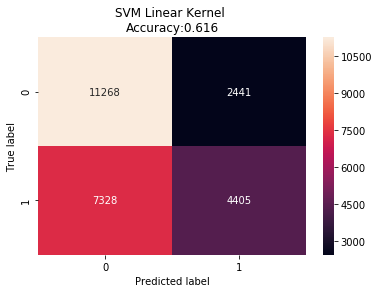

In [91]:
plot_confusion(grid_clf_acc)
#SVM linear acc: 0.565(added medical speciality)

In [ ]:
X_train.to_csv("Xtrain.csv")

# Applying PCA

In [97]:
pca = PCA(n_components = 8)
pca.fit(X_train)
variance = pca.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features



array([ 47.3,  75.4,  85.6,  93.8,  97.2,  99.5, 100. , 100.1])

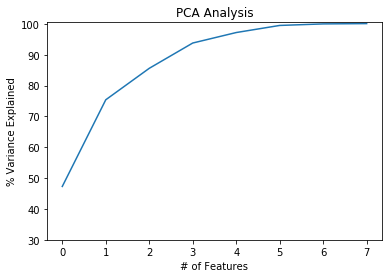

In [98]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.show()

In [99]:
pca.fit(X_train)
pca.fit(X_test)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)

In [100]:
%%time
clf = LinearSVC()
#clf.fit(X_t_train, y_train)
grid_values = [
  {'C': [0.1, 1, 10, 100, 1000]}  
 ]

grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, n_jobs=4)
grid_clf_acc.fit(X_t_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_t_test) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)
#Grid best score (accuracy):  0.5618923292402671
#Grid best score (accuracy):  0.5751206434316354(adding medical speciality)
#score 0.5486569084767573 2
#PCA 0.5724396782841823 8 components

Grid best parameter (max. accuracy):  {'C': 1}
Grid best score (accuracy):  0.6150490016246528
Wall time: 52.8 s


In [ ]:
def plot_confusion_pca(clf):
    svm_predicted_mc = clf.predict(X_t_test)
    confusion_mc = confusion_matrix(y_test, svm_predicted_mc)
    df_cm = pd.DataFrame(confusion_mc, 
                         index = [i for i in range(0,2)], columns = [i for i in range(0,3)])

    plt.figure(figsize=(6,4))
    ax_ticks= ['<30', '>30', 'NO']
    sns.heatmap(df_cm, annot=True, xticklabels=ax_ticks, yticklabels=ax_ticks, fmt='g')
    plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                           svm_predicted_mc)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(y_test, svm_predicted_mc, average = 'micro')))
    print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(y_test, svm_predicted_mc, average = 'macro')))
    print('Micro-averaged f1 = {:.2f} (treat instances equally)'
          .format(f1_score(y_test, svm_predicted_mc, average = 'micro')))
    print('Macro-averaged f1 = {:.2f} (treat classes equally)'
          .format(f1_score(y_test, svm_predicted_mc, average = 'macro')))
    print(classification_report(y_test, svm_predicted_mc))

plot_confusion_pca(grid_clf_acc)
#0.566 PCA 8